<font size = 6><h1 align = center>Monte Carlo Fun </h1 ></font>      

<font size = 4><h2 align = center> Derek Sikorski </font><h2>

---
---
---


<font size = 5><h1 align = center>File Summary</h1 ></font>      

**Purpose:** 
This file is meant to handle MCing data used for the Hyperion SMF project. The data broadly includes:
1. COSMOS2020 photometry
2. Assorted ground-based spectroscopy
3. HST grism data

**Outputs:**
This code produces two separate catalogs of MCed redshifts. One is for the COSMOS photometry while the other is for any other is for any other assortment of observations. The logic is that the photoz's are drawn completely randomly for all galaxies in the sample whereas the galaxies with other observations maybe be chosen by a variety of functions. Therefore, it is easiest to simply replace the redshifts of the galaxies with extra observations in place.

**General Logic:**


---
---
---

In [9]:
import numpy as np
from scipy.stats import skewnorm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from tqdm.notebook import tqdm

<font size = 6><h1 align = center>Loading Data </h1 ></font>      

**COSMOS 2020**

In [10]:
# COSMOS CATALOG
cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos_file[1].data

# COSMOS PDFs
pdf_file = fits.open(r"C:\Users\sikor\OneDrive\Desktop\BigData\COSMOS2020\COSMOS2020_CLASSIC_R1_v2.2_LEPHARE_PZ_p3.fits")
c20_pdfs = pdf_file[0].data

print("C20 Catalog shape: ", c20p.shape)
print("C20 PDF shape: ", c20_pdfs.shape)
print("\nRedshift dist: ", c20_pdfs[0])

C20 Catalog shape:  (1720700,)
C20 PDF shape:  (1720701, 1002)

Redshift dist:  [  nan  0.    0.01 ...  9.98  9.99 10.  ]


**Ground-based Spec**

In [11]:
# Load catalog
specz_cat = np.loadtxt("./Data/master_specz_COSMOS_BF_v4b.cat", dtype=object)

# Fixing formatting: 
new_array = []  # allocate to reformatted data

for _idx in range(specz_cat.shape[1]):
    # Try to convert to float if possible 
    try:      col = specz_cat[:,_idx].astype(np.float32)
    except:   col = specz_cat[:,_idx]
    new_array.append(col)

c20s = np.array(new_array, dtype=object).T  # Convert to np.ndarray

# Find which spectra are not in COSMOS
_ms = np.where(c20s[:,0] == -99)[0]   # idxs of missing spectra

print("GB-spectra shape: ", c20s.shape)
print(f"Spec of COSMOS objects: ", c20s.shape[0]-_ms.shape[0])
print("Unmatched spectra: ", _ms.shape[0])

GB-spectra shape:  (42776, 32)
Spec of COSMOS objects:  40214
Unmatched spectra:  2562


**HST Grism**

In [12]:
# Load catalog
griz_cat = np.loadtxt("./Data/HST_Hyp_zcat.v1.3.cat", skiprows=1, usecols=range(16), dtype=object)

# Fixing formatting: 
new_array = []  # allocate to reformatted data

for idx in range(griz_cat.shape[1]):
    # Try to convert to float if possible 
    try:     col = griz_cat[:,idx].astype(np.float32)
    except:  col = griz_cat[:,idx]
    new_array.append(col)

griz = np.array(new_array, dtype=object).T  # Convert to np.ndarray


# Find which spectra are not in COSMOS
_mg = np.where(griz[:,4] == -99)[0]   # idxs of missing grism spec


print("GB-spectra shape: ", griz.shape)
print(f"Spec of COSMOS objects: ", griz.shape[0]-_mg.shape[0])
print("Unmatched spectra: ", _mg.shape[0])

GB-spectra shape:  (12764, 16)
Spec of COSMOS objects:  12711
Unmatched spectra:  53


---
---
---

<font size = 6><h1 align = center>Define Some General Functions </h1 ></font>      

<font size = 6><h1 align = center>MC Photometry </h1 ></font>      

In [13]:
## Define parameters ##
n_mcs = 100
# np.random.seed(1)
# --------------------------------

## Allocate array to store redshift samplings ##
good_data = np.where((c20p["lp_type"] == 0) |( c20p["lp_type"] == 2))[0]
MCed_phots = np.zeros(shape=(len(c20p), n_mcs+2))
print("Number of objects to MC: ", len(good_data))

## Sample Redshifts ##

# Make z-grid
pdf_zs = c20_pdfs[0][1:]
print("Redshift grid: ", pdf_zs)

bads = []

# Loop through each cosmos galaxy and sample PDF
for _cid, gal_data in tqdm(enumerate(c20p), total=len(c20p)):


    pdf_values = c20_pdfs[_cid+1][1:]  # Get PDF vals  (note first row of PDFs is z-grid)
    try:
        z_samp = np.random.choice(pdf_zs, size=n_mcs, p=pdf_values/pdf_values.sum())    # Sample PDF
    except:
        z_samp = [-99]*n_mcs
        bads.append([_cid+1, gal_data['lp_type']])

    MCed_phots[_cid] = np.concatenate(([_cid+1, gal_data['lp_zPDF']], z_samp))   # Add new row = [COSMOS_ID + lp_zPDF + sampled z's]



Number of objects to MC:  1681047
Redshift grid:  [ 0.    0.01  0.02 ...  9.98  9.99 10.  ]


  0%|          | 0/1720700 [00:00<?, ?it/s]

C:\Users\sikor\AppData\Local\Temp\ipykernel_4340\960376546.py:25: RuntimeWarning: invalid value encountered in divide
  z_samp = np.random.choice(pdf_zs, size=n_mcs, p=pdf_values/pdf_values.sum())    # Sample PDF


In [14]:
bads = np.array(bads)

for t in [0, 1, 2, -99]:
    
    num = len(np.where(bads[:,1] == t)[0])
    tot = len(np.where(c20p['lp_type'] == t)[0])
    print(t, ' = ', num,  f'({tot})')

0  =  0 (1677646)
1  =  0 (31672)
2  =  0 (3401)
-99  =  3306 (7981)


In [15]:
## Save File ##
np.save(r'C:\Users\sikor\OneDrive\Desktop\BigData\COSMOS2020\C20p_MC100', MCed_phots)

---
---
---

<font size = 6><h1 align = center>MC Spectroscopy </h1 ></font>      

**Pick Best Spec**

Some COSMOS objects appear more than once in the GB and HST catalogs. Therefore, the first step is making separate lists the catalogs and picking the best observation for a given COSMOS object

- *Note* For the HST catalog, blended objects are discarded. That is, objects with separate HST observations but a common COSMOS ID. These have blended photometry and thus cannot be MCed (or really have physical parameters derived unless via spectroscopy).

In [61]:
## GB Spec ##

gb_spec = []
test_counter = 0
t3 = 0


# Loop through unique COSMOS IDs and pull best object
for cid in tqdm(np.unique(c20s[:,0])):

    if cid > 0 :        # it has a COSMOS ID

        _spot = np.where(c20s[:,0] == cid)  # find matches to the C20 ID in GB catalog

        gb_zs, gb_qfs = c20s[:,11][_spot], c20s[:,13][_spot]    # pull spec_z and qf

        if max(gb_zs) > 0: # Some objects have z_spec = 0

            gb_spec.append([cid, gb_zs[np.argmax(gb_qfs)], gb_qfs[np.argmax(gb_qfs)]])  # Add whichever flag is the best

            # See if there was a qf tie
            count_max = np.sum(gb_qfs == np.max(gb_qfs))
            if count_max > 1: test_counter += 1    

        else: t3 += 1


gb_spec = np.array(gb_spec)            

print("Number COSMOS objects with z_spec = -99:   ", t3)
print("Number of obects with a quality flag tie:  ", test_counter)

  0%|          | 0/40215 [00:00<?, ?it/s]

Number COSMOS objects with z_spec = -99:    6798
Number of obects with a quality flag tie:   0


In [62]:
## HST Spec ##

hst_spec = []
test_counter1 = 0
test_counter2 = 0

# Loop through unique COSMOS IDs and pull best object
for cid in tqdm(np.unique(griz[:,4])):

    if cid > 0 :        # it has a COSMOS ID

        _spot = np.where(griz[:,4] == cid)  # find matches to the C20 ID in HST catalog

        _spot = np.delete(_spot, np.where(griz[:,5][_spot] == 1))   # remove blended objects

        if len(_spot) > 0:  # Some non-blended objects
            hst_z, hst_qfs  = griz[:,13][_spot], griz[:,15][_spot]    # pull spec_z and qf

            hst_spec.append([cid, hst_z[np.argmax(hst_qfs)], hst_qfs[np.argmax(hst_qfs)]])  # Add whichever flag is the best

            count_max = np.sum(hst_qfs == np.max(hst_qfs))
            if count_max > 1: test_counter += 1

        else:
            test_counter2 += 1  # If there are blended objects
                
hst_spec = np.array(hst_spec)

print("Number of obects with a quality flag tie:  ", test_counter1)
print("Number of blended objects removed:  ", test_counter2)

  0%|          | 0/12590 [00:00<?, ?it/s]

Number of obects with a quality flag tie:   0
Number of blended objects removed:   118


**Combine Data**

Pull data from GB spectra and HST spectra to make an array for each object with:

---> [COSMOS ID, GB redshift, GB quality flag, HST redshift, HST quality flag]

From this, can then make a general loop that handles each object.

- *Note* each object must have at least a COSMOS ID. Also must match the COSMOS ID rather than the spec ID (see **test 1**)

In [100]:
## Combining HST and GB surveys
test = [0, 0, 0]

# Allocate Array #
all_spec = []

for cid in tqdm(np.unique(np.concatenate((gb_spec[:,0], hst_spec[:,0])))):

    gb_data = gb_spec[gb_spec[:,0] == cid].flatten()
    hst_data = hst_spec[hst_spec[:,0] == cid].flatten()


    if len(hst_data) == 0:  # There is only a gb spectrum
        all_spec.append([cid, gb_data[1], gb_data[2], -99, -99])
        test[0] += 1
    elif len(gb_data) == 0: # There is only an HST spec
        all_spec.append([cid, -99, -99, hst_data[1], hst_data[2]])
        test[1] += 1
    else:   # There is both
        all_spec.append([cid, gb_data[1], gb_data[2], hst_data[1], hst_data[2]])
        test[2] += 1

all_spec = np.array(all_spec)
all_spec[:,0] = all_spec[:,0].astype(int)

print("Number of objects with just gb data: ", test[0])
print("Number of objects with just hst data: ", test[1])
print("Number of objects with both data: ", test[2])

  0%|          | 0/43699 [00:00<?, ?it/s]

Number of objects with just gb data:  31228
Number of objects with just hst data:  10283
Number of objects with both data:  2188


**MC the Spectra**

Now I can MC the spectra. In general, the MC chooses between the COSMOS p(z), the gb spectra, or a Gaussian around the HST spec. The choice is based on a quality flag. The confidences associated with each quality flag are:

Ground-based:
- $2 \leq qf < 3$ = 0.7
- $9 \leq qf < 10$ = 0.7
- $3 \leq qf < 5$ = 0.993

HST:
- $qf = 3 \to 0.668$
- $qf = 4 \to 0.818$
- $qf = 5 \to 0.925$

The HST redshifts are drawn from a Gaussian centered on the grism redshift and with width $\sigma = 46/14100\cdot (1+z)$

In [97]:
def z_chooser(qfs, qfg, niter):
    """Return a list of length=niter with integers corresponding to the MC choice. 0 = p(z), 1 = GB spec, 2 = HST"""

    # Get the probs
    prob_s = np.select([ ((qfs>=2)&(qfs<3)), ((qfs>=9)&(qfs<10)), ((qfs>=3)&(qfs<5)) ], [0.7, 0.7, 0.993], default=0)
    prob_g = np.select([qfg==3, qfg==4, qfg==5], [0.668, 0.818, 0.925], default=0)

    ps = [prob_s, prob_g]   # pack up for easier use       ---> Know at least 1 isn't 0

    rns = np.random.random(niter)
    choice = np.zeros(niter)

    if ps[0] == 0: # No GB
        choice[rns < ps[1]] = 2     # Say when we're choosing HST

    elif ps[1] == 0:    # No HST
        choice[rns < ps[0]] = 1     # Say when we're choosing GB
    
    else:   # Have both GB and HST
        p_max, p_min = max(ps), min(ps)
        thresh = p_max + p_min*(1-p_min)    # Upper threshold for worse spec

        choice[(rns<p_max)] = np.argmax(ps) + 1     # Choose the better spectrum
        choice[(rns>=p_max) & (rns<thresh)] = np.argmin(ps) + 1

    best = np.argmax(ps)  + 1   # Which is better    

    return best, choice

In [101]:
## Define parameters ##
n_mcs = 100
# np.random.seed(1)
# --------------------------------
pdf_values = c20_pdfs[_cid+1][1:]  # Get PDF vals  (note first row of PDFs is z-grid)

MCed_specs = np.zeros(shape=(len(all_spec), n_mcs+2 ))
MCed_choice = np.zeros(shape=(len(all_spec), n_mcs+2 ))

bads = []

for _row, s in tqdm(enumerate(all_spec), total=len(all_spec)):

    best, choices = z_chooser(s[2], s[4], n_mcs)  # list of 0, 1, 2 corresponding to choice of that mc

    pdf_values = c20_pdfs[int(s[0])][1:]

    best_zspec = s[best*2]   # Choose the spec with the better prob for un_MCed sample

    try:
        phot_zs = np.random.choice(pdf_zs, size=n_mcs, p=pdf_values/pdf_values.sum())    # Sample PDF
        gbz = [s[1]]*100
        hstz = np.random.normal(loc=s[3], scale=46/14100*(1+np.abs(s[3])), size=n_mcs )     # note np.abs avoids errors w/ missing hst

        zs = np.select([choices==0, choices==1, choices==2], [phot_zs, gbz, hstz])

        MCed_specs[_row] = np.concatenate(([s[0], best_zspec], zs))
        MCed_choice[_row] = np.concatenate(([s[0], best], choices))


    except:
        MCed_specs[_row] = np.concatenate(([s[0], best_zspec], np.full(n_mcs, np.nan))) # Fill MCs with NaN
        MCed_choice[_row] = np.concatenate(([s[0], best], np.full(n_mcs, np.nan)))

        bads.append(s)



  0%|          | 0/43699 [00:00<?, ?it/s]

C:\Users\sikor\AppData\Local\Temp\ipykernel_4340\2202853077.py:21: RuntimeWarning: invalid value encountered in divide
  phot_zs = np.random.choice(pdf_zs, size=n_mcs, p=pdf_values/pdf_values.sum())    # Sample PDF


**Pack into Photz list**

In [ ]:
total_MCs = np.copy(MCed_phots)

for row in MCed_specs:
    total_MCs[int(row[0])-1] = row

np.save(r'C:\Users\sikor\OneDrive\Desktop\BigData\COSMOS2020\C20_tot100', total_MCs)
np.save(r'C:\Users\sikor\OneDrive\Desktop\BigData\COSMOS2020\C20_totChoice', MCed_choice)

<font size = 6><h1 align = center>Assorted Tests </h1 ></font>      

**Test 1 (Resolved)**

Checking for any objects in the HST catalog that:

1. Have a corresponding ground-based counterpart (i.e. ID_spec != -99)
2. Have a different Cosmos ID from said counterpart

Find:
- Number of HST grism with GB ID that is not in GB catalog:  0
- Number of HST grism with different CID than GB counterpart:  2
- [Spec_ID, GB_CID, HST_CID] = 
 [['431589', 552174.0, 1048424.0], ['406226', 510072.0, 670389.0]]

*Resolution:*

In both cases, the spec ID reported in the HST catalog appears twice in the ground-based catalog. The two entries in the ground-based catalogs correspond to different objects from different surveys that happen to have the same ID. Thus, matching COSMOS ID as opposed to spec_ID is needed

In [ ]:
t1 = 0
t2_list = []


for g in tqdm(griz):

    if g[9] != '-99':     # This is part of a GB survey
        _sid = np.where(c20s[:,1] == g[9])  # Find objects which have the same GB survey id

        if len(_sid[0]) == 0: t1 += 1   # If the object has a survey id but is not in the catalog
        else:
            cids = c20s[:,0][_sid]      # Pull cosmos IDs
            for cid in cids:
                if cid != g[4]: 
                    t2_list.append([g[9], cid, g[4]])

print('Number of HST grism with GB ID that is not in GB catalog: ', t1)
print('Number of HST grism with different CID than GB counterpart: ',len(t2_list))
print("[Spec_ID, GB_CID, HST_CID] = \n", t2_list)


  0%|          | 0/12764 [00:00<?, ?it/s]

Number of HST grism with GB ID that is not in GB catalog:  0
Number of HST grism with different CID than GB counterpart:  2
[Spec_ID, GB_CID, HST_CID] = 
 [['431589', 552174.0, 1048424.0], ['406226', 510072.0, 670389.0]]


**Test 2**

Look at distribution of lp_types the spectra correspond to

In [ ]:
type_counter = [0,0,0,0]    # [-99, 0, 1, 2]
type_idxs = [[], [], [], []]

for s in tqdm(all_spec):
    
    lpt = c20p[int(s[0])-1]["lp_type"]


    _type = np.select([lpt==-99, lpt==0, lpt==1, lpt==2], [0, 1,2,3])

    type_counter[_type] += 1
    type_idxs[_type].append(int(s[0]))

print(type_counter)

  0%|          | 0/50056 [00:00<?, ?it/s]

[965, 44947, 2273, 1871]


1


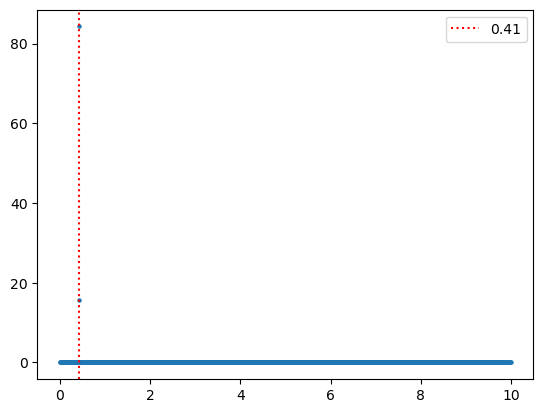

In [ ]:
_c = type_idxs[2][2]
pdf_zs = c20_pdfs[0][1:]
print(c20p[_c-1]["lp_type"])

plt.scatter(pdf_zs, c20_pdfs[_c][1:], s=5)
plt.axvline(c20p[_c-1]["lp_zPDF"], color='r', ls=':', label=f'{round(c20p[_c-1]["lp_zPDF"], 2)}')
plt.legend()
plt.show()